# Import Libraries

In [9]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

# Data Preprocessing

In [10]:
SEED        = 88
IMG_SIZE    = (224, 224)    # load at original size first
BATCH_SIZE  = 256
LABEL_MODE  = "categorical" # one‑hot labels straight away

classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

def load_split(split):
    dataset=tf.keras.preprocessing.image_dataset_from_directory("./datasets/"+split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset

train_ds = load_split("train")
val_ds = load_split("validate")
test_ds = load_split("test")

Found 4148 files belonging to 3 classes.
Found 1788 files belonging to 3 classes.
Found 1785 files belonging to 3 classes.


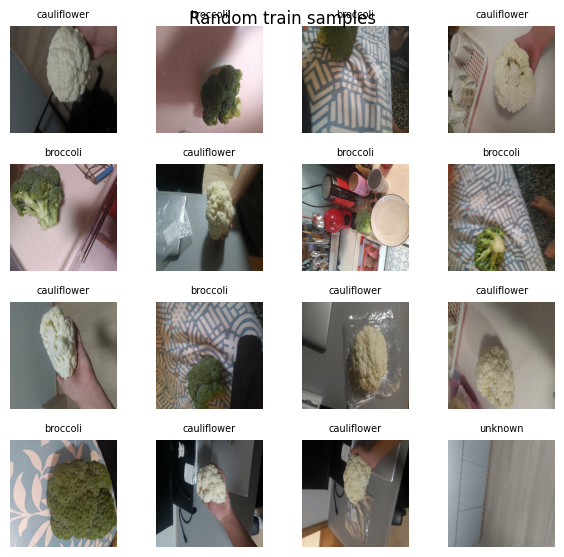

In [11]:
plt.figure(figsize=(6,6))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

In [13]:

num_classes = 3

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(*IMG_SIZE,3)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides =1))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten(input_shape=(*IMG_SIZE, 3)))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Optimizer = optimizers.Adam(0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Optimizer,
              metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 activation_3 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 activation_4 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 221, 221, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 219, 219, 64)      18496     
                                                      

In [ ]:
history = model.fit(train_ds,
          batch_size=50,
          epochs=20,
          verbose=1,
          validation_data = train_ds)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

tf.keras.models.save_model(model,'my_model.hdf5')

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_2/activation_3/Relu' defined at (most recent call last):
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell
      result = self._run_cell(
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell
      result = runner(coro)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\dionc\AppData\Local\Temp\ipykernel_26972\1058364864.py", line 1, in <module>
      history = model.fit(train_ds,
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\layers\core\activation.py", line 59, in call
      return self.activation(inputs)
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\dionc\anaconda3\envs\mlai\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_2/activation_3/Relu'
OOM when allocating tensor with shape[256,32,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_2/activation_3/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1653]

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined